<a href="https://colab.research.google.com/github/VladislavasR/CodeAcademyAI_Final_Colab/blob/main/Final_Colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Demo project and data

In [2]:
import io
import pandas as pd
import numpy as np
import matplotlib  as mpl
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
rcParams['figure.figsize']=20,10
from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense
from sklearn.preprocessing import MinMaxScaler

In [3]:
data_url = 'https://raw.githubusercontent.com/MindaugasBernatavicius/DeepLearningCourse/master/09_Sequential_Data_Analysis/NSE-Tata-Global-Beverages-Limited.csv'
df = pd.read_csv(data_url)
# df["Date"]=pd.to_datetime(df.Date,format="%Y-%m-%d")
# df.index=df['Date']
df = df[::-1]

In [4]:
# Check if normalization is needed
df.describe()['Close']

count    2035.00000
mean      149.45027
std        48.71204
min        80.95000
25%       120.05000
50%       141.25000
75%       156.90000
max       325.75000
Name: Close, dtype: float64

In [6]:
# data=df.sort_index(ascending=False,axis=0)
data=df.sort_index(ascending=False, axis=0).reset_index(drop=True)
new_dataset=pd.DataFrame(index=range(0,len(df)),columns=['Date','Close'])

for i in range(0,len(data)):
    new_dataset["Date"][i]=data['Date'][i]
    new_dataset["Close"][i]=data["Close"][i]

train_data = new_dataset[0:987]
valid_data = new_dataset[987:]

new_dataset.index=new_dataset.Date
new_dataset.drop("Date",axis=1,inplace=True)

Scaling

In [7]:
scaler=MinMaxScaler(feature_range=(0,1))
scaled_data=scaler.fit_transform(new_dataset)

Construct the sequences

In [8]:
x_train_data, y_train_data=[],[]
for i in range(60, len(train_data)):
    x_train_data.append(scaled_data[i-60:i,0])
    y_train_data.append(scaled_data[i,0])

# convert to numpy
x_train_data, y_train_data = np.array(x_train_data), np.array(y_train_data)
print(x_train_data.shape)

# reshape it to 3D
x_train_data=np.reshape(x_train_data,(x_train_data.shape[0],x_train_data.shape[1],1))

# to see how the shape changes we can again print it out
print(x_train_data.shape)
print(y_train_data.shape)

(927, 60)
(927, 60, 1)
(927,)


In [9]:
lstm_model=Sequential()
lstm_model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train_data.shape[1], 1)))
lstm_model.add(LSTM(units=50))
lstm_model.add(Dense(1))

lstm_model.compile(loss='mean_squared_error', optimizer='adam')
history = lstm_model.fit(x_train_data,y_train_data, epochs=20, batch_size=50, verbose=1)

Epoch 1/20
19/19 [==============================] - 5s 66ms/step - loss: 0.0064
Epoch 2/20
19/19 [==============================] - 1s 65ms/step - loss: 0.0013
Epoch 3/20
19/19 [==============================] - 1s 64ms/step - loss: 7.3506e-04
Epoch 4/20
19/19 [==============================] - 1s 66ms/step - loss: 6.9928e-04
Epoch 5/20
19/19 [==============================] - 1s 65ms/step - loss: 6.0493e-04
Epoch 6/20
19/19 [==============================] - 1s 64ms/step - loss: 5.7700e-04
Epoch 7/20
19/19 [==============================] - 1s 65ms/step - loss: 5.5837e-04
Epoch 8/20
19/19 [==============================] - 1s 64ms/step - loss: 5.5235e-04
Epoch 9/20
19/19 [==============================] - 1s 65ms/step - loss: 5.3767e-04
Epoch 10/20
19/19 [==============================] - 1s 64ms/step - loss: 5.0375e-04
Epoch 11/20
19/19 [==============================] - 1s 64ms/step - loss: 5.0349e-04
Epoch 12/20
19/19 [==============================] - 1s 64ms/step - loss: 5.0646e-

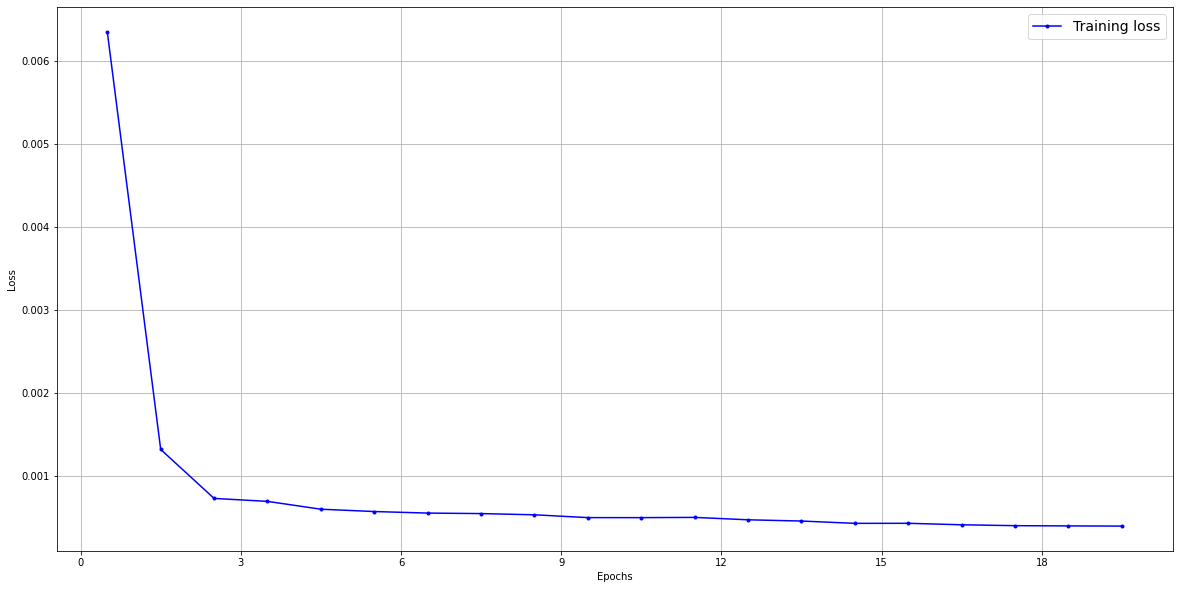

In [10]:
def plot_learning_curves(loss):
    plt.plot(np.arange(len(loss)) + 0.5, loss, "b.-", label="Training loss")
    plt.gca().xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))
    # plt.axis([1, 20, 0, 0.05])
    plt.legend(fontsize=14)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.grid(True)

plot_learning_curves(history.history["loss"])
plt.show()

Construct dataset for prediction

In [11]:
inputs_data=new_dataset[len(new_dataset)-len(valid_data)-60:].values
inputs_data=inputs_data.reshape(-1,1)
inputs_data=scaler.transform(inputs_data)
inputs_data.shape

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"


(1108, 1)

In [12]:
X_test=[]
for i in range(60,inputs_data.shape[0]):
    X_test.append(inputs_data[i-60:i,0])
X_test=np.array(X_test)
X_test=np.reshape(X_test,(X_test.shape[0],X_test.shape[1],1))

In [13]:
predicted_closing_price=lstm_model.predict(X_test)
predicted_closing_price=scaler.inverse_transform(predicted_closing_price)

33/33 [==============================] - 1s 16ms/step


In [14]:
train_data=new_dataset[:987]
valid_data=new_dataset[987:]

In [15]:
valid_data = valid_data.assign(Predictions=predicted_closing_price)

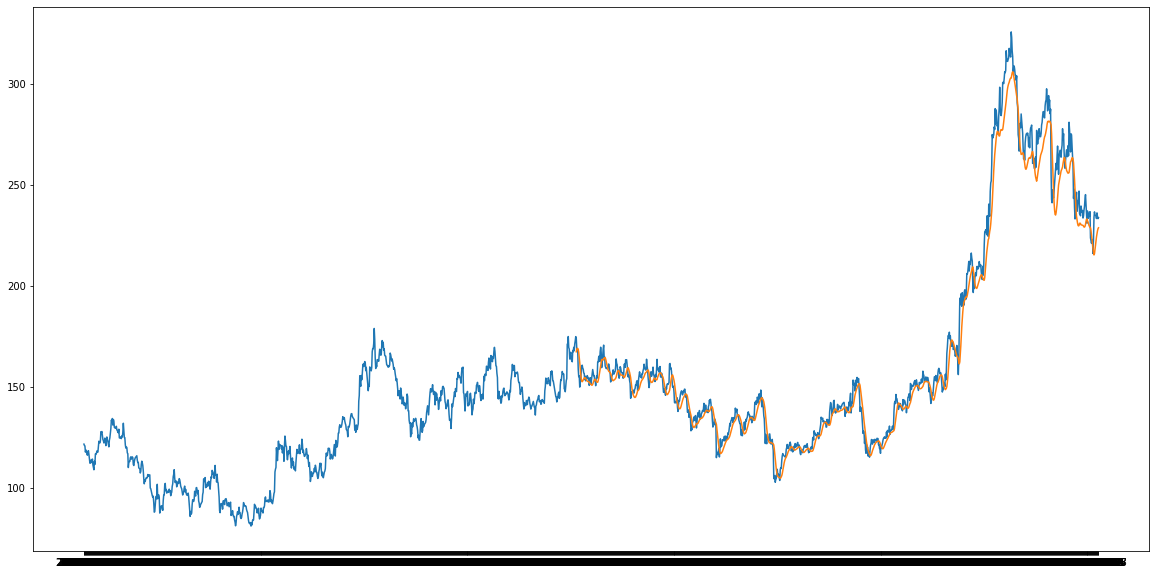

In [16]:
# print(valid_data)
plt.plot(new_dataset['Close'])
# plt.plot(train_data['Close'])
# plt.plot(valid_data['Close'])
# plt.plot(valid_data['Predictions'])
plt.plot(valid_data.index, predicted_closing_price)

In [17]:
# Calculate the MSE for predictions
from sklearn.metrics import mean_squared_error
mean_squared_error(valid_data['Close'],predicted_closing_price) 

# Increase the epoch count and retrain the network, see if MSE improves

# These were calculated on reversed data
# 66.74
# 69.52
# 34.15 - batch size: 50, epoch: 20

# these were calculated on the data in correct order
# 88.41349351955924

59.92033016041978

RNN

In [41]:
import io
import pandas as pd
import numpy as np
import matplotlib  as mpl
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
rcParams['figure.figsize']=20,10

from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense, GRU
from sklearn.preprocessing import MinMaxScaler

# data_url = 'https://raw.githubusercontent.com/MindaugasBernatavicius/DeepLearningCourse/master/09_Sequential_Data_Analysis/NSE-Tata-Global-Beverages-Limited.csv'
# df = pd.read_csv(data_url)
# df["Date"]=pd.to_datetime(df.Date,format="%Y-%m-%d")
# df.index=df['Date']
data_url = 'https://raw.githubusercontent.com/MindaugasBernatavicius/DeepLearningCourse/master/09_Sequential_Data_Analysis/NSE-Tata-Global-Beverages-Limited.csv'
df = pd.read_csv(data_url)
# df["Date"]=pd.to_datetime(df.Date,format="%Y-%m-%d")
# df.index=df['Date']
df = df[::-1]

In [40]:
# data=df.sort_index(ascending=True,axis=0)
# new_dataset=pd.DataFrame(index=range(0,len(df)),columns=['Date','Close'])

# for i in range(0,len(data)):
#     new_dataset["Date"][i]=data['Date'][i]
#     new_dataset["Close"][i]=data["Close"][i]

# train_data = new_dataset[0:987]
# valid_data = new_dataset[987:]

# new_dataset.index=new_dataset.Date
# new_dataset.drop("Date",axis=1,inplace=True)

# scaler=MinMaxScaler(feature_range=(0,1))
# scaled_data=scaler.fit_transform(new_dataset)
# x_train_data,y_train_data=[],[]
# for i in range(60,len(train_data)):
#     x_train_data.append(scaled_data[i-60:i,0])
#     y_train_data.append(scaled_data[i,0])

# x_train_data,y_train_data=np.array(x_train_data),np.array(y_train_data)
# x_train_data=np.reshape(x_train_data,(x_train_data.shape[0],x_train_data.shape[1],1))

     Date Close
2030  NaN   NaN
2031  NaN   NaN
2032  NaN   NaN
2033  NaN   NaN
2034  NaN   NaN


In [42]:
# data=df.sort_index(ascending=False,axis=0)
data=df.sort_index(ascending=False, axis=0).reset_index(drop=True)
new_dataset=pd.DataFrame(index=range(0,len(df)),columns=['Date','Close'])

for i in range(0,len(data)):
    new_dataset["Date"][i]=data['Date'][i]
    new_dataset["Close"][i]=data["Close"][i]

train_data = new_dataset[0:987]
valid_data = new_dataset[987:]

new_dataset.index=new_dataset.Date
new_dataset.drop("Date",axis=1,inplace=True)

new_dataset.tail(5)

,Close
Date,
2018-09-24,233.3
2018-09-25,236.1
2018-09-26,234.25
2018-09-27,233.25
2018-09-28,233.75


In [43]:
gru_model=Sequential()
gru_model.add(GRU(units=50, return_sequences=True, input_shape=(x_train_data.shape[1],1)))
gru_model.add(GRU(units=50))
gru_model.add(Dense(1))

# gru_model=Sequential()
# gru_model.add(GRU(units=10, return_sequences=True, input_shape=(x_train_data.shape[1],1)))
# gru_model.add(GRU(units=10))
# gru_model.add(Dense(1))

gru_model.compile(loss='mean_squared_error', optimizer='adam')
history = gru_model.fit(x_train_data, y_train_data, epochs=20, batch_size=50,verbose=1) # epoch=1 and bs=1000 gives the worst predictions possible 

inputs_data_orig=new_dataset[len(new_dataset)-len(valid_data)-60:].values
inputs_data=inputs_data_orig.reshape(-1,1)
inputs_data=scaler.transform(inputs_data)

X_test=[]
for i in range(60,inputs_data.shape[0]):
    X_test.append(inputs_data[i-60:i,0])
X_test=np.array(X_test)
X_test=np.reshape(X_test,(X_test.shape[0],X_test.shape[1],1))

Epoch 1/20
19/19 [==============================] - 7s 67ms/step - loss: 0.0086
Epoch 2/20
19/19 [==============================] - 1s 66ms/step - loss: 0.0015
Epoch 3/20
19/19 [==============================] - 1s 66ms/step - loss: 4.0669e-04
Epoch 4/20
19/19 [==============================] - 1s 64ms/step - loss: 3.1025e-04
Epoch 5/20
19/19 [==============================] - 1s 66ms/step - loss: 2.6558e-04
Epoch 6/20
19/19 [==============================] - 1s 66ms/step - loss: 2.5663e-04
Epoch 7/20
19/19 [==============================] - 1s 66ms/step - loss: 2.5271e-04
Epoch 8/20
19/19 [==============================] - 1s 67ms/step - loss: 2.4722e-04
Epoch 9/20
19/19 [==============================] - 1s 66ms/step - loss: 2.3542e-04
Epoch 10/20
19/19 [==============================] - 1s 65ms/step - loss: 2.3365e-04
Epoch 11/20
19/19 [==============================] - 1s 67ms/step - loss: 2.2750e-04
Epoch 12/20
19/19 [==============================] - 1s 65ms/step - loss: 2.1726e-

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"


In [44]:
# predict on all sequences
predicted_closing_price=gru_model.predict(X_test)
predicted_closing_price=scaler.inverse_transform(predicted_closing_price)

# # predict on 1 sequence
# seq_of_interest = 150 
# # X_test[150] this will be a 2D array, the 150th sequence of size (60, 1)
# # ... to make it 3D, I need to add another dimension: (1, 60, 1)
# predicted_closing_price=gru_model.predict(X_test[np.newaxis, seq_of_interest])
# predicted_closing_price=scaler.inverse_transform(predicted_closing_price)

33/33 [==============================] - 1s 14ms/step


ValueError: ignored

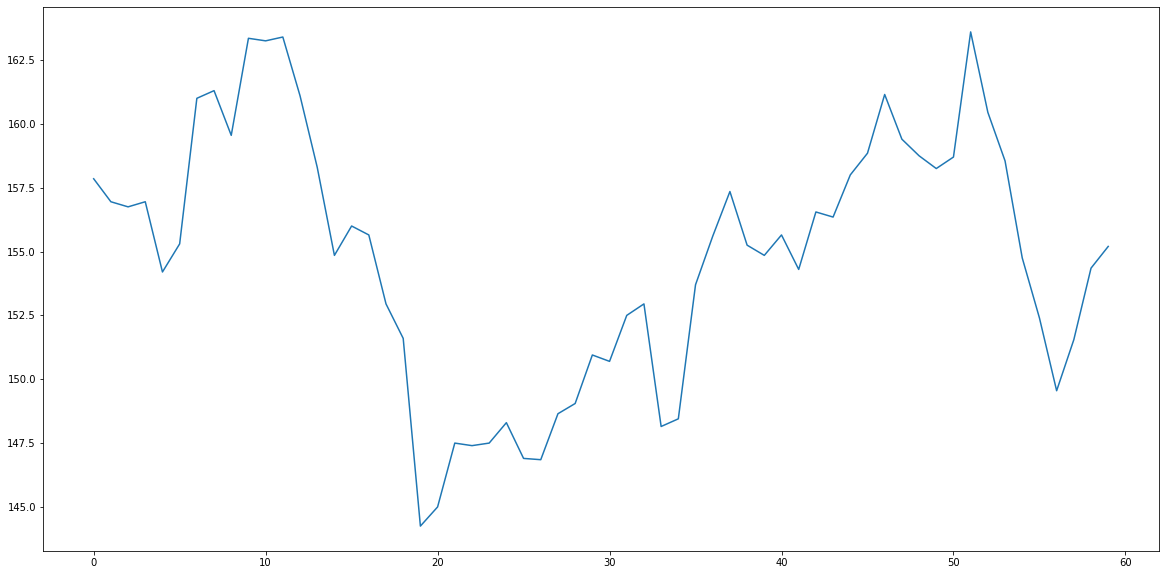

In [32]:
# uncomment this when plotting predictions on 1 subsequence

plt.plot(scaler.inverse_transform(X_test[seq_of_interest]).squeeze())
plt.plot(len(X_test[seq_of_interest]), predicted_closing_price.squeeze(), "ro-")
plt.plot(len(X_test[seq_of_interest+1]), scaler.inverse_transform(X_test[seq_of_interest+1])[-1:], "rx-")

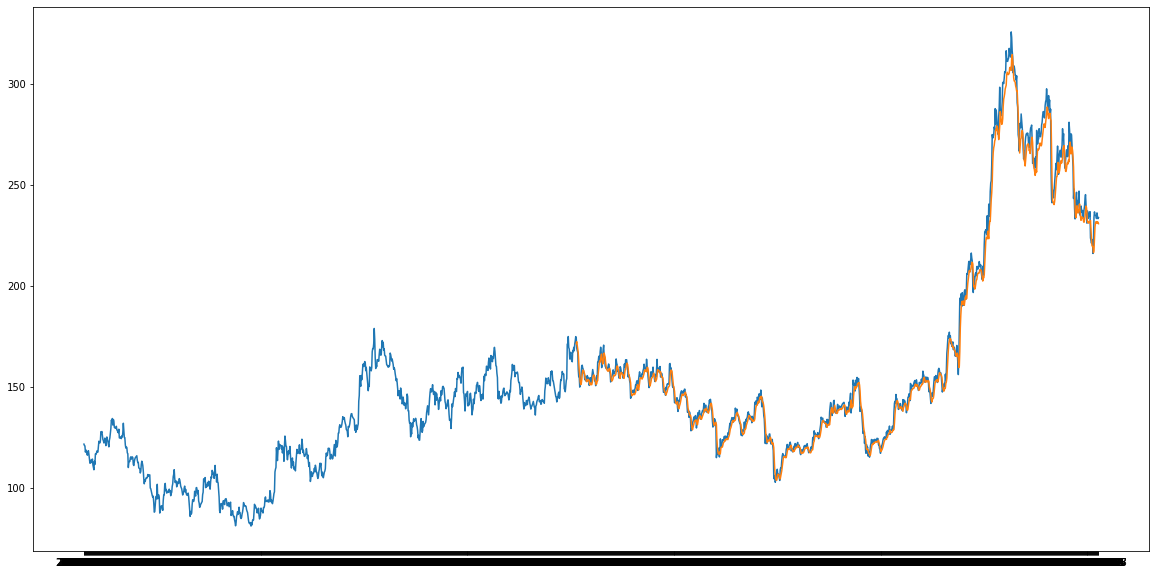

In [45]:
# print(valid_data)
plt.plot(new_dataset['Close'])
# plt.plot(train_data['Close'])
# plt.plot(valid_data['Close'])
# plt.plot(valid_data['Predictions'])
plt.plot(valid_data.index, predicted_closing_price)

In [46]:
from sklearn.metrics import mean_squared_error
mean_squared_error(valid_data['Close'],predicted_closing_price) 

24.715103206970607